## 摘要

- 30分後の為替の変動を予測してみる

### データセット

- [GAIN Capital](http://ratedata.gaincapital.com/)
- 通貨ペア: USD/JPY
- 期間: 2018-03-04 〜 2018-04-19

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
df = pd.concat([pd.read_csv(fpath, parse_dates=["RateDateTime"]) for fpath in sorted(glob.glob("*.csv"))])

In [3]:
df = df.sort_values(by="RateDateTime").reset_index(drop=True)

In [4]:
df.head()

,lTid,cDealable,CurrencyPair,RateDateTime,RateBid,RateAsk
0,6474889452,D,USD/JPY,2018-03-04 17:00:09.560,105.419,105.489
1,6474889479,D,USD/JPY,2018-03-04 17:00:17.810,105.462,105.532
2,6474889521,D,USD/JPY,2018-03-04 17:00:26.060,105.458,105.528
3,6474889554,D,USD/JPY,2018-03-04 17:00:35.310,105.476,105.546
4,6474889598,D,USD/JPY,2018-03-04 17:00:38.310,105.461,105.531


### 予測データの作成

- 2,3日後の為替の変動を予測し，何もしない, 買い， 売りを決定する．
- 0.01円(0.005%の手数料)を取られる

| 行動        | 値 | 説明                                      |
| ------------ | --- | ------------------------------------------- |
| 買い        | 1  |  現在の買値(Ask) < 将来の売値(Bid) |
| 空売り      | -1 |  現在の売値(Bid) > 将来の買値(Ask) |
| 何もしない | 0  |  それ以外 |    

In [5]:
T = 3*(10**3) # 約30分後
margin = 0.03 # 3銭(0.015%前後)の手数料
df["TargetRateBid"] = df["RateBid"].shift(-T)
df["TargetRateAsk"] = df["RateAsk"].shift(-T)
df["TargetRateDateTime"] = df["RateDateTime"].shift(-T)
df["Target"] = 0 # 何もしない
df.loc[(df["TargetRateAsk"] + margin < df["RateBid"]), "Target"] = -1 # 売りのタイミング
df.loc[(df["TargetRateBid"] > df["RateAsk"] + margin), "Target"] = 1 # 買いのタイミング

In [6]:
df.head()

,lTid,cDealable,CurrencyPair,RateDateTime,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target
0,6474889452,D,USD/JPY,2018-03-04 17:00:09.560,105.419,105.489,105.618,105.644,2018-03-04 17:46:37.553,1
1,6474889479,D,USD/JPY,2018-03-04 17:00:17.810,105.462,105.532,105.621,105.647,2018-03-04 17:46:37.803,1
2,6474889521,D,USD/JPY,2018-03-04 17:00:26.060,105.458,105.528,105.623,105.648,2018-03-04 17:46:38.053,1
3,6474889554,D,USD/JPY,2018-03-04 17:00:35.310,105.476,105.546,105.619,105.645,2018-03-04 17:46:38.303,1
4,6474889598,D,USD/JPY,2018-03-04 17:00:38.310,105.461,105.531,105.639,105.647,2018-03-04 17:46:38.553,1


In [7]:
df["Dow"] = df["RateDateTime"].dt.dayofweek
df["Hour"] = df["RateDateTime"].dt.hour
df["Diff"] = df["RateAsk"] - df["RateBid"]
# フィボナッチすごい, cf. https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9
nums = [2, 3, 5, 8, 13, 21, 34]
cols = []
for num in nums:
    interval = 10 * num
    col = "RateBidMedian_%05d" % interval
    cols.append(col)
    df[col] = df["RateBid"].rolling(window=interval).median()
df["RateBidMedian"] = df[cols].apply(np.median, axis=1).median()
df["RateBid/RateBidMedian"] = df["RateBid"] / df["RateBidMedian"]

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [8]:
df.dropna(inplace=True)

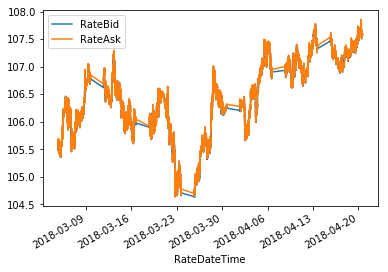

In [9]:
df.set_index("RateDateTime")[["RateBid", "RateAsk"]].plot()

In [10]:
use_columns = [u"Diff", u"Dow", u"Hour", "RateBid/RateBidMedian"]

In [11]:
num_train = int(len(df) * 0.7)
train_df = df[:num_train]
test_df = df[num_train:]

In [12]:
train_df["RateDateTime"].min(), train_df["RateDateTime"].max()

(Timestamp('2018-03-04 17:08:00.057000'),
 Timestamp('2018-04-04 16:58:30.197000'))

In [13]:
test_df["RateDateTime"].min(), test_df["RateDateTime"].max()

(Timestamp('2018-04-04 16:58:47.697000'),
 Timestamp('2018-04-20 15:00:02.903000'))

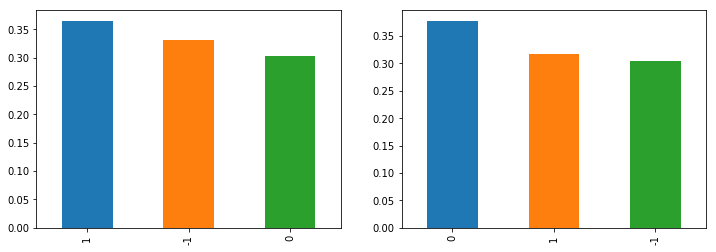

In [14]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
train_df["Target"].value_counts(1).plot(kind="bar", ax=axes[0])
test_df["Target"].value_counts(1).plot(kind="bar", ax=axes[1]);

In [15]:
X_train = train_df[use_columns].values
y_train = train_df["Target"].values
X_test = test_df[use_columns].values
y_test = test_df["Target"].values

In [16]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
y_pred = clf.predict(X_test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
print "Accuracy: %.4f" % accuracy_score(y_test, y_pred)
print "Recall:       %.4f" % recall_score(y_test, y_pred, average="macro")
print "Precision:  %.4f" % precision_score(y_test, y_pred, average="macro")
print "F1:             %.4f" % f1_score(y_test, y_pred, average="macro")

Accuracy: 0.3420
Recall:       0.3600
Precision:  0.3767
F1:             0.2929


## まとめ

- XGBoostで直近の為替変動を予測してみたところ，正答率は34%とじゃんけんと変わらない．
- また，3月末に傾向が変わってそうなので，こういった変化点を検出して対策を取らないと痛い目に合いそう．

## References

> [1]. [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), kaggle, 2017.

> [2]. [GAIN Capital](http://ratedata.gaincapital.com/)